In [1]:
import numpy as np
import pandas as pd
import pandas.io.data as web
import matplotlib.pyplot as plt
import datetime

import mean_reversion as mr
import hedge_ratio as hr
import portfolio
import returns
import util

%matplotlib inline

In [2]:
#start_dt = datetime.datetime(2006, 4, 26)
#end_dt = datetime.datetime(2012, 4, 9)
start_dt = datetime.datetime(2012, 1, 1)
end_dt = datetime.datetime(2015, 12, 31)

In [3]:
# Interesting:
# USO, EWC, lookback=25, entryZScore=2, exitZScore=1, leverage=2
# DBC, DJP, lookback=20, entryZScore=1, exitZScore=0, 2012-12-11 -> 2015-12-31
# DBO, DJP, lookback=20, entryZScore=1, exitZScore=0, 2012-12-11 -> 2015-12-31
# DBO, EWA, lookback=15, entryZScore=1.0, exitZScore=0, 2012-12-11 -> 2015-12-31
# * DBO, DBC, lookback=15, entryZScore=1.4, exitZScore=0, 2012-12-11 -> 2015-12-31
# * GLD, DBC, lookback=10, entryZScore=1.0, exitZScore=0, 2012-12-11 -> 2015-12-31
# EWC, DJP, lookback=10, entryZScore=2.0, exitZScore=0.6, 2012-12-11 -> 2015-12-31


def fetch(ticker):
    global start_dt, end_dt
    return web.DataReader(ticker, 'yahoo', start_dt, end_dt)['Adj Close']

#SPY = fetch("SPY")
#DIA = fetch("DIA")
#QQQ = fetch("QQQ")
#IWM = fetch("IWM")
#GLD = fetch("GLD")
#USO = fetch("USO")
#DBO = fetch("DBO")
#EWA = fetch("EWA")
EWC = fetch("EWC")
#DBC = fetch("DBC")
DJP = fetch("DJP")
#UNG = fetch("UNG")


In [4]:
x = EWC
y = DJP

universe = pd.DataFrame({'x': x, 'y': y})

In [5]:
# Run a CADF and get better than 95%
mr.cadf(x, y, method="tls", regression="c")

(-1.6336707756365541,
 0.46556987317188819,
 0,
 1001,
 {'1%': -3.4368995989062348,
  '10%': -2.5683096665272789,
  '5%': -2.8644316780522177},
 4881.5743315633845)

In [6]:
x.corr(y)

0.22504771827996425

Lookback: 10 -> CADF: mean -2.62, std 1.22
Lookback: 20 -> CADF: mean -2.39, std 0.90
Lookback: 30 -> CADF: mean -2.32, std 0.92
Lookback: 50 -> CADF: mean -2.20, std 0.82


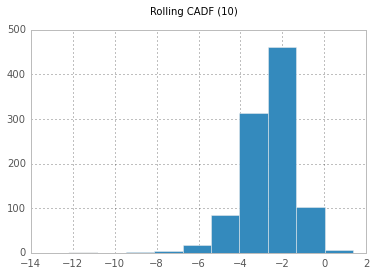

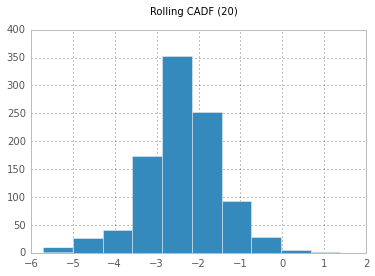

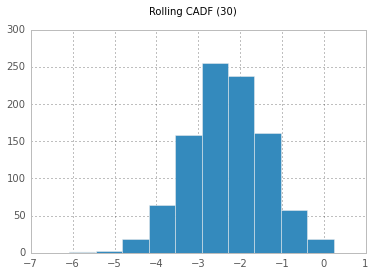

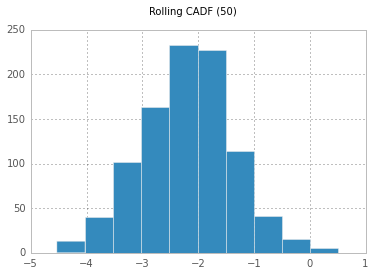

In [7]:
# There may be something to watching CADF over time instead
def cadf(win):
    return mr.cadf(
        win.x, 
        win.y, 
        method="tls", 
        regression="c")[0]

# Free param
for cadf_lookback in [10, 20, 30, 50]:
    rolling_cadf = util.rolling_apply(
        universe, cadf_lookback, cadf)

    # We hope to see a mean down below -2 and -2.5, since this is where test
    # values start to get significant for the CADF test.
    plt.figure()
    plt.suptitle('Rolling CADF (%d)' % cadf_lookback)
    rolling_cadf.hist()
    print 'Lookback: %d -> CADF: mean %.2f, std %.2f' % (
        cadf_lookback, rolling_cadf.mean(), rolling_cadf.std())


array([ 91.26218591])

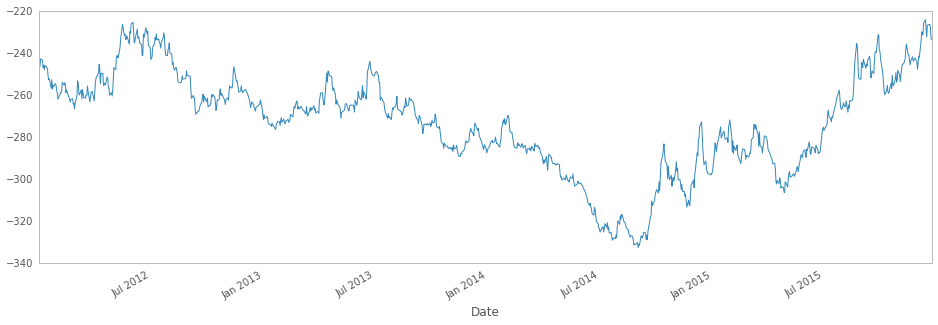

In [8]:
# Get static hedge ratio (warning, lookahead bias here)
static_hr = hr.hedge_ratio(x, y, method="tls")

# Construct base portfolio
port = y - static_hr * x
port.plot(figsize=(16,5))

mr.halflife(port)

In [9]:
# Reset these values for optimizing
lookback = 0
entryZScore = 1.0
exitZScore = 0.0

In [16]:
x.index[50:150]

DatetimeIndex(['2012-03-15', '2012-03-16', '2012-03-19', '2012-03-20',
               '2012-03-21', '2012-03-22', '2012-03-23', '2012-03-26',
               '2012-03-27', '2012-03-28', '2012-03-29', '2012-03-30',
               '2012-04-02', '2012-04-03', '2012-04-04', '2012-04-05',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-16', '2012-04-17', '2012-04-18',
               '2012-04-19', '2012-04-20', '2012-04-23', '2012-04-24',
               '2012-04-25', '2012-04-26', '2012-04-27', '2012-04-30',
               '2012-05-01', '2012-05-02', '2012-05-03', '2012-05-04',
               '2012-05-07', '2012-05-08', '2012-05-09', '2012-05-10',
               '2012-05-11', '2012-05-14', '2012-05-15', '2012-05-16',
               '2012-05-17', '2012-05-18', '2012-05-21', '2012-05-22',
               '2012-05-23', '2012-05-24', '2012-05-25', '2012-05-29',
               '2012-05-30', '2012-05-31', '2012-06-01', '2012-06-04',
      

In [26]:
test_index = np.random.rand(len(x)) < 0.8

In [28]:
# Optimizing lookback...
# Plot some hedge lookback values against resulting sharpe ratio
import strategies
import optimize
reload(strategies)
reload(optimize)

strategy = lambda lookback: \
    strategies.rolling_hedge_mean_revert_strategy(x, y, lookback)
    
lookback_v_sharpe = optimize.vs_sharpe_table('lookback', [5, 10, 15, 20, 25, 30, 40, 50], strategy)
lookback_v_sharpe

,lookback,sharpe
0,5,1.394388
1,10,-0.286650
2,15,0.918893
3,20,0.538855
4,25,0.618162
5,30,0.225314
6,40,0.170190
7,50,0.085780


In [39]:
# lookback = 25
lookback = lookback_v_sharpe.sort('sharpe')['lookback'].iloc[-1]
lookback

5

In [36]:
lb_results = []
for i in range(20):
    lb_results.append(optimize.vs_sharpe(
        'lookback', [5, 10, 15, 20], 
        strategy, index=np.random.rand(len(x)) < 0.8))
    
lb_results

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

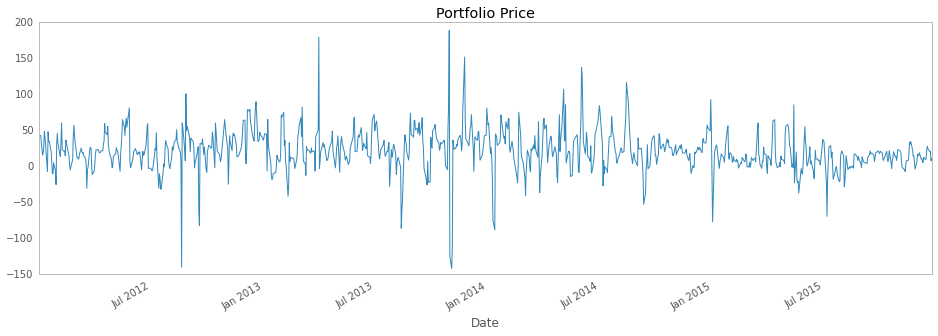

In [45]:
strategy = strategies.rolling_hedge_mean_revert_strategy
(prices, weights, units) = strategy(x, y, lookback)
port = portfolio.portfolio_price(prices, weights)
port.plot(figsize=(16,5), title='Portfolio Price')

In [46]:
# Ok, now let's look at the half-life of this portfolio, this needs to be low (under 30)
mr.halflife(port)

array([ 1.52440747])

In [47]:
# What does the adfuller look like for this rolling hedge portfolio?
# Does it show signs of mean reversion?
import statsmodels.tsa.stattools as sms
print 'CADF: %.2f' % sms.adfuller(port)[0]
print
print 'Hurst: %.2f' % mr.hurst_exponent(port.pct_change().fillna(0))[0]
print
print 'Vratio test'
print mr.vratiotest(port)


CADF: -12.56

Hurst: 0.54

Vratio test
             M1        M2
k=2   17.247232  7.666675
k=4   18.575136  8.967255
k=8   16.590960  9.441600
k=16  13.311969  9.211984
k=32  11.833883  9.361662


In [49]:
# Get returns for basic zScore continuous mean-reversion
zScore = util.rolling_z_score(port, lookback)
rets = portfolio.portfolio_returns(universe, weights, -zScore)
returns.annual_sharpe(rets['returns'])

1.3943882477843148

Bollinger Band Mean Reversion
        Total return: 0.580
        Sharpe ratio: 1.57
        APR: 0.125
        Drawdown: -0.07
        Max Time in Drawdown: 113
    
355 total trades
0.35 trades per day
2.82 days per trade
0.73% time in market
732 bars in market


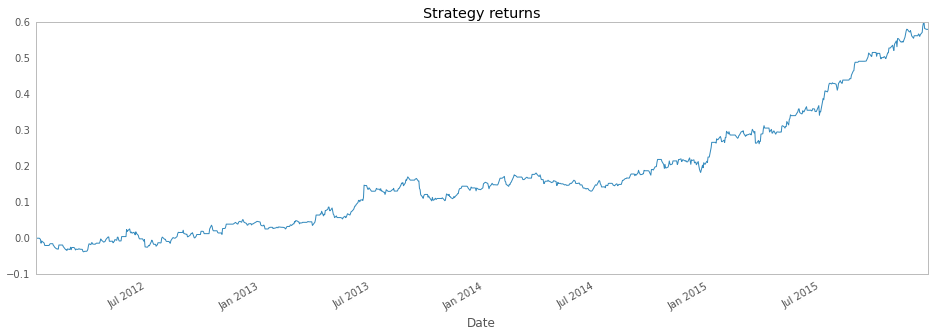

In [53]:
b_units = strategies.bollinger_band_units(zScore, entryZScore=entryZScore, exitZScore=exitZScore)

# Random experiment - static weights. Basically, force hedge weights to be static for the duration
# of any particular trade.
unit_changes = b_units != b_units.shift().fillna(0)
weights_v2 = weights.copy()
weights_v2[~unit_changes] = np.nan
weights_v2['x'][0] = 0
weights_v2['y'][0] = 0
weights_v2 = weights_v2.fillna(method='ffill')

b_rets = portfolio.portfolio_returns(universe, weights_v2, b_units)['returns']
#(b_rets, positions, pnl, grossMktVal) = portfolio.portfolio_returns(universe, weights, b_units)

b_rets = b_rets
print returns.report_str(b_rets, "Bollinger Band Mean Reversion")

# We want total trades to be high-ish (for statistic significance), but other
# than that, frequency might be a matter of preference? (Still figuring that out)
import strategies
reload(strategies)

print '%d total trades' % strategies.number_of_trades(b_units)
print '%.2f trades per day' % strategies.trades_per_period(b_units)
print '%.2f days per trade' % (1 / strategies.trades_per_period(b_units))
print '%.2f%% time in market' % strategies.time_in_market_percent(b_units)
print '%d bars in market' % len(b_units[b_units != 0])

returns.cumret(b_rets).plot(figsize=(16,5), title='Strategy returns')

In [55]:
reload(portfolio)
portfolio.portfolio_shares(universe, weights, units, 500)

,x,y
Date,,
2012-01-03,0.000000,0.000000
2012-01-04,0.000000,0.000000
2012-01-05,0.000000,0.000000
2012-01-06,0.000000,0.000000
2012-01-09,-7.905875,7.113475
2012-01-10,-7.349553,7.334279
2012-01-11,-5.112107,8.699279
2012-01-12,-2.422730,-10.398284
2012-01-13,0.525727,-11.591472


In [56]:
# TODO: Figure out a way to measure "smoothness" of equity curve above, and trendiness as well

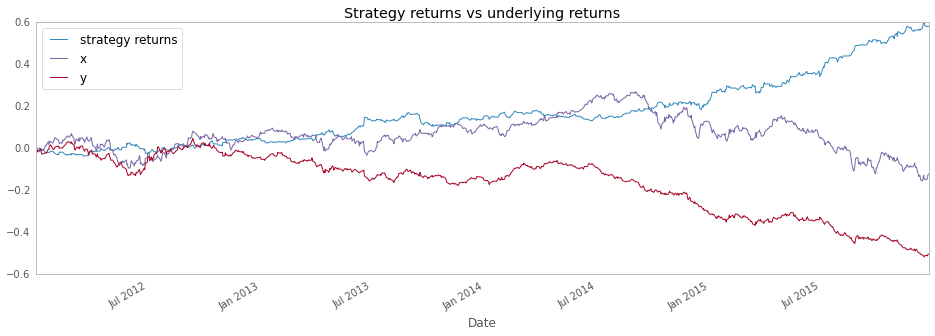

In [57]:
returns.cumret(pd.concat([
    pd.DataFrame({'strategy returns': b_rets}), 
    universe.pct_change()
], axis=1)).plot(figsize=(16,5), title='Strategy returns vs underlying returns')

In [58]:
# We want total trades to be high-ish (for statistic significance), but other
# than that, frequency might be a matter of preference? (Still figuring that out)
import strategies
reload(strategies)

print '%d total trades' % strategies.number_of_trades(b_units)
print '%.2f trades per day' % strategies.trades_per_period(b_units)
print '%.2f days per trade' % (1 / strategies.trades_per_period(b_units))
print '%.2f%% time in market' % strategies.time_in_market_percent(b_units)
print '%d bars in market' % len(b_units[b_units != 0])

355 total trades
0.35 trades per day
2.82 days per trade
0.73% time in market
732 bars in market


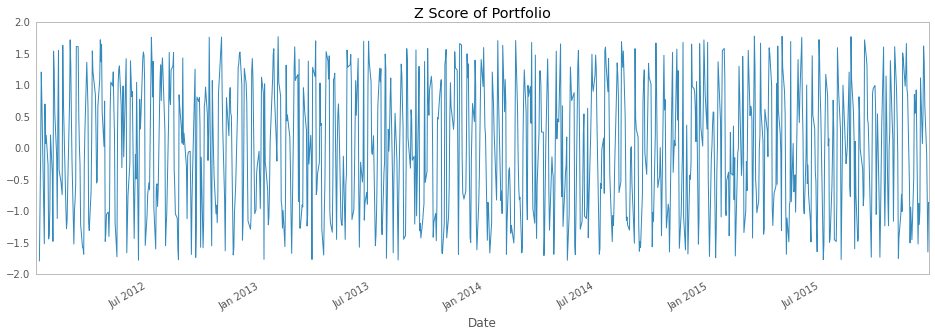

In [59]:
zScore.plot(figsize=(16,5), title="Z Score of Portfolio")

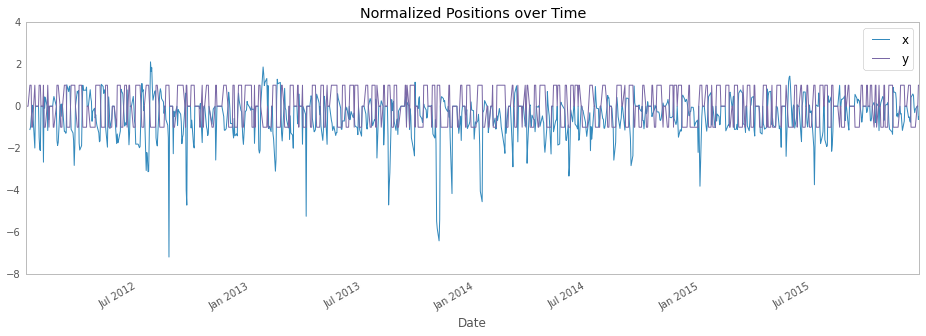

In [60]:
(weights * b_units).plot(figsize=(16,5), title='Normalized Positions over Time')